In [ ]:
1. 인코더 디코더 모델

In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
# 데이터 경로
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# 파일 리스트 만들기 (확장자 신경쓰지 않고 다 가져옴)
x_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
y_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]

x_filenames.sort()
y_filenames.sort()

# train/test 분리
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(
    x_filenames, y_filenames, test_size=0.2, random_state=42
)

print(f"x_train: {len(x_train_filenames)}, x_test: {len(x_test_filenames)}")


x_train: 240, x_test: 60


In [4]:
def load_image_and_mask(image_path, mask_path):
    # 입력 이미지 로드 (BMP로 읽기)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=3)   # BMP 읽기
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0

    # 마스크(라벨) 로드 (BMP로 읽고, 흑백 변환)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_bmp(mask, channels=3)     # BMP 읽기
    mask = tf.image.rgb_to_grayscale(mask)           # RGB -> Grayscale
    mask = tf.image.resize(mask, (224, 224))
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask


In [5]:
BATCH_SIZE = 8  # (너무 크면 GPU 터짐)

train_ds = tf.data.Dataset.from_tensor_slices((x_train_filenames, y_train_filenames))
test_ds = tf.data.Dataset.from_tensor_slices((x_test_filenames, y_test_filenames))

train_ds = train_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ train_ds, test_ds 생성 완료")


✅ train_ds, test_ds 생성 완료


In [6]:
def build_simple_encoder_decoder(output_channels):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Encoder
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)

    # Decoder
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)

    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation=None)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

# 모델 만들기
simple_model = build_simple_encoder_decoder(output_channels=1)

# 모델 컴파일
simple_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("✅ simple_model 생성 및 컴파일 완료")


✅ simple_model 생성 및 컴파일 완료


In [7]:
EPOCHS = 4

history_simple = simple_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

print("✅ 학습 완료!")


Epoch 1/4
30/30 [==============================] - 7s 41ms/step - loss: 0.5180 - accuracy: 0.9476 - val_loss: 0.3268 - val_accuracy: 0.9493
Epoch 2/4
30/30 [==============================] - 2s 26ms/step - loss: 0.2253 - accuracy: 0.9476 - val_loss: 0.1821 - val_accuracy: 0.9493
Epoch 3/4
30/30 [==============================] - 1s 26ms/step - loss: 0.1795 - accuracy: 0.9476 - val_loss: 0.1771 - val_accuracy: 0.9493
Epoch 4/4
30/30 [==============================] - 1s 27ms/step - loss: 0.1763 - accuracy: 0.9476 - val_loss: 0.1852 - val_accuracy: 0.9493
✅ 학습 완료!


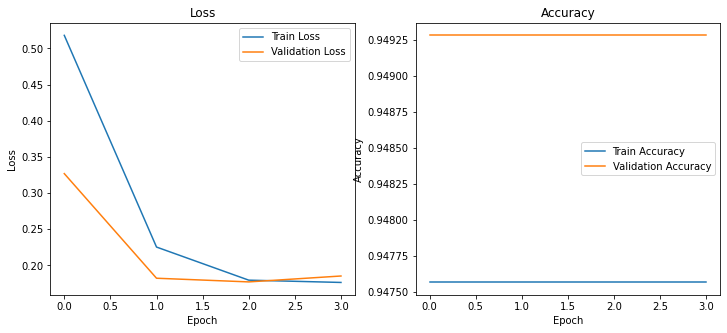

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Loss 그래프
    plt.figure(figsize=(12, 5))

    # 1. Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 사용 방법
plot_training_history(history_simple)


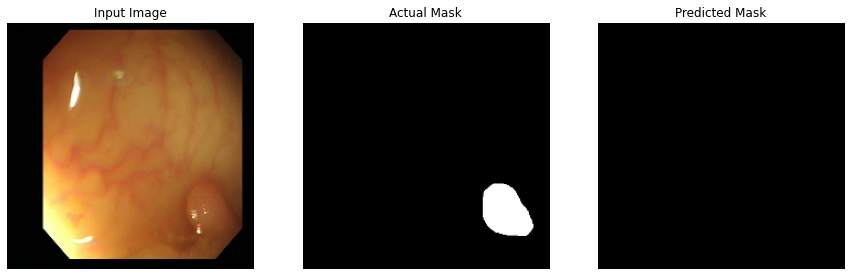

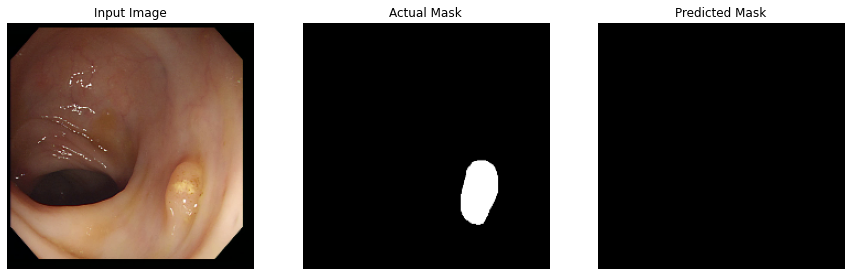

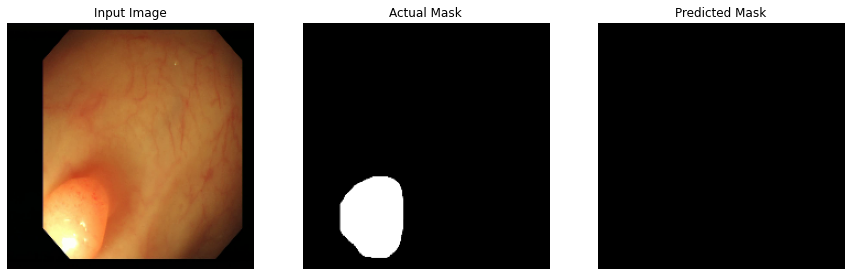

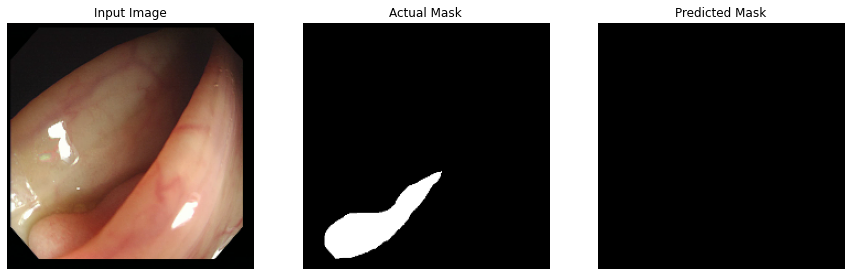

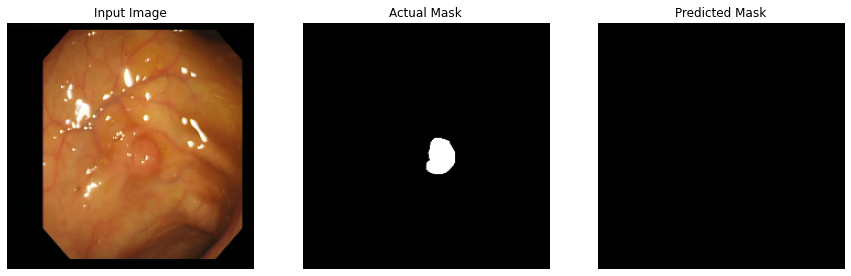

In [9]:
def show_predictions(model, dataset, num_images=5):
    # 배치 하나 가져오기
    for images, masks in dataset.take(1):
        preds = model.predict(images)

        for i in range(num_images):
            plt.figure(figsize=(15, 5))

            # 입력 이미지
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title('Input Image')
            plt.axis('off')

            # 실제 마스크
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title('Actual Mask')
            plt.axis('off')

            # 예측 마스크
            plt.subplot(1, 3, 3)
            pred_mask = tf.sigmoid(preds[i, :, :, 0])  # 시그모이드 적용 후
            pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)  # 0.5 기준 이진화
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()

# 사용 방법
show_predictions(simple_model, test_ds, num_images=5)


In [ ]:
2. U-net 모델

In [10]:
def build_unet(output_channels):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation=None)(c9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 모델 생성
unet_model = build_unet(output_channels=1)

# 컴파일
unet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("✅ U-Net 모델 생성 및 컴파일 완료")


✅ U-Net 모델 생성 및 컴파일 완료


In [ ]:
3. Pretrained Encoder (EfficientNetB0) + U-Net 구조

In [11]:
def build_pretrained_unet(output_channels):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Encoder Layer를 가져오기
    skips = [
        base_model.get_layer(name).output
        for name in ['block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation']
    ]

    encoder_output = base_model.output

    # U-Net Decoder
    x = encoder_output
    for skip in reversed(skips):
        x = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)

    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation=None)(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

    return model

# 모델 생성
pretrained_unet_model = build_pretrained_unet(output_channels=1)

# 컴파일
pretrained_unet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("✅ Pretrained EfficientNetB0 + U-Net 모델 생성 및 컴파일 완료")


16719872/16705208 [==============================] - 0s 0us/step
✅ Pretrained EfficientNetB0 + U-Net 모델 생성 및 컴파일 완료


In [ ]:
각 모델의 학습

In [12]:
# simple_model 학습
history_simple = simple_model.fit(train_ds, validation_data=test_ds, epochs=10)

# unet_model 학습
history_unet = unet_model.fit(train_ds, validation_data=test_ds, epochs=10)

# pretrained_unet_model 학습
history_pretrained_unet = pretrained_unet_model.fit(train_ds, validation_data=test_ds, epochs=10)


Epoch 1/10
30/30 [==============================] - 2s 30ms/step - loss: 0.1726 - accuracy: 0.9476 - val_loss: 0.1737 - val_accuracy: 0.9493
Epoch 2/10
30/30 [==============================] - 1s 26ms/step - loss: 0.1712 - accuracy: 0.9476 - val_loss: 0.1745 - val_accuracy: 0.9493
Epoch 3/10
30/30 [==============================] - 2s 27ms/step - loss: 0.1726 - accuracy: 0.9476 - val_loss: 0.1804 - val_accuracy: 0.9493
Epoch 4/10
30/30 [==============================] - 1s 26ms/step - loss: 0.1728 - accuracy: 0.9476 - val_loss: 0.1725 - val_accuracy: 0.9493
Epoch 5/10
30/30 [==============================] - 2s 27ms/step - loss: 0.1707 - accuracy: 0.9476 - val_loss: 0.1770 - val_accuracy: 0.9493
Epoch 6/10
30/30 [==============================] - 1s 26ms/step - loss: 0.1756 - accuracy: 0.9476 - val_loss: 0.1827 - val_accuracy: 0.9493
Epoch 7/10
30/30 [==============================] - 1s 26ms/step - loss: 0.1703 - accuracy: 0.9476 - val_loss: 0.1718 - val_accuracy: 0.9493
Epoch 8/10
30

In [ ]:
U-net모델 학습

In [13]:
# U-Net 모델 학습
EPOCHS = 4

history_unet = unet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

print("✅ U-Net 학습 완료!")


Epoch 1/4
30/30 [==============================] - 11s 357ms/step - loss: 0.1756 - accuracy: 0.9476 - val_loss: 0.1771 - val_accuracy: 0.9493
Epoch 2/4
30/30 [==============================] - 11s 361ms/step - loss: 0.1733 - accuracy: 0.9476 - val_loss: 0.1800 - val_accuracy: 0.9493
Epoch 3/4
30/30 [==============================] - 12s 361ms/step - loss: 0.1712 - accuracy: 0.9476 - val_loss: 0.1784 - val_accuracy: 0.9493
Epoch 4/4
30/30 [==============================] - 12s 361ms/step - loss: 0.1731 - accuracy: 0.9476 - val_loss: 0.1735 - val_accuracy: 0.9493
✅ U-Net 학습 완료!


In [ ]:
U-net 학습 그래프

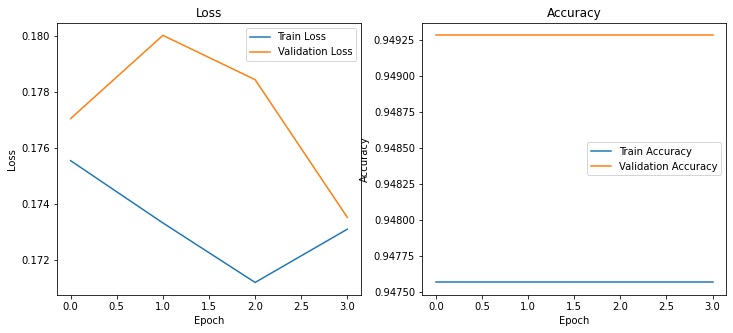

In [14]:
plot_training_history(history_unet)


In [ ]:
Pretrained EfficientNetB0 U-Net 모델 학습 코드

In [15]:
# Pretrained EfficientNetB0 + U-Net 모델 학습
EPOCHS = 4

history_pretrained_unet = pretrained_unet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

print("✅ Pretrained EfficientNetB0 + U-Net 학습 완료!")


Epoch 1/4
30/30 [==============================] - 16s 503ms/step - loss: 0.0231 - accuracy: 0.9896 - val_loss: 0.4072 - val_accuracy: 0.9494
Epoch 2/4
30/30 [==============================] - 16s 508ms/step - loss: 0.0218 - accuracy: 0.9898 - val_loss: 0.4462 - val_accuracy: 0.9499
Epoch 3/4
30/30 [==============================] - 16s 513ms/step - loss: 0.0177 - accuracy: 0.9912 - val_loss: 0.6791 - val_accuracy: 0.9500
Epoch 4/4
30/30 [==============================] - 16s 517ms/step - loss: 0.0171 - accuracy: 0.9919 - val_loss: 0.2984 - val_accuracy: 0.9507
✅ Pretrained EfficientNetB0 + U-Net 학습 완료!


In [ ]:
Pretrained EfficientNetB0 U-Net 학습 그래프 코드

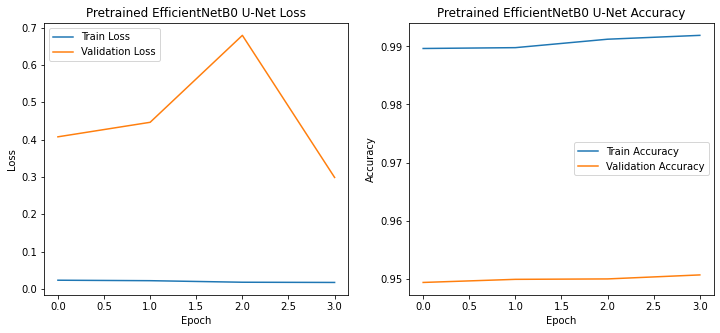

In [16]:
# 학습 그래프 그리는 함수
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))

    # 1. Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 사용 방법
plot_training_history(history_pretrained_unet, model_name="Pretrained EfficientNetB0 U-Net")


In [ ]:
3개 모델 학습 그래프 한 번에 비교하는 코드

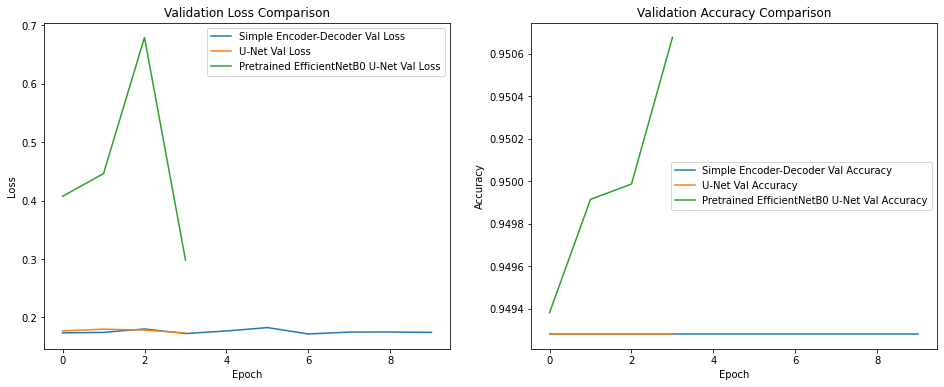

In [17]:
import matplotlib.pyplot as plt

def plot_all_training_histories(histories, labels):
    plt.figure(figsize=(16, 6))

    # 1. Loss 비교
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Accuracy 비교
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 사용 방법
histories = [history_simple, history_unet, history_pretrained_unet]
labels = ['Simple Encoder-Decoder', 'U-Net', 'Pretrained EfficientNetB0 U-Net']

plot_all_training_histories(histories, labels)


In [ ]:
 3개 모델 예측 결과 한 번에 비교하는 코드

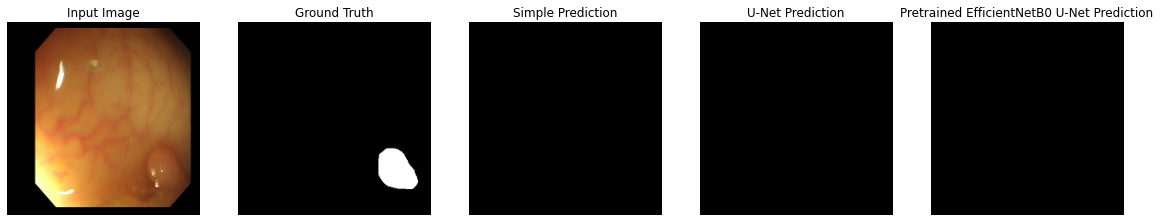

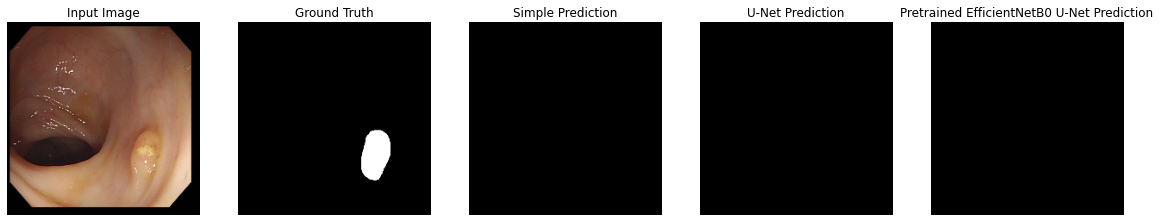

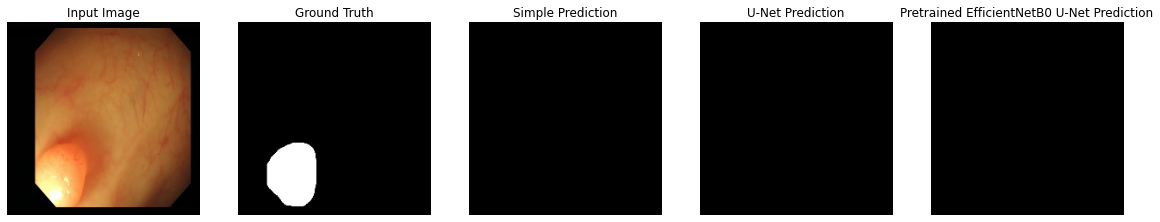

In [18]:
def show_comparison(models, dataset, model_labels, num_images=3):
    for images, masks in dataset.take(1):
        # 각 모델로 예측 수행
        preds_list = [model.predict(images) for model in models]

        for i in range(num_images):
            plt.figure(figsize=(20, 8))

            # 1. Input Image
            plt.subplot(1, len(models) + 2, 1)
            plt.imshow(images[i])
            plt.title('Input Image')
            plt.axis('off')

            # 2. Ground Truth Mask
            plt.subplot(1, len(models) + 2, 2)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')

            # 3. Each model's prediction
            for j, preds in enumerate(preds_list):
                pred_mask = tf.sigmoid(preds[i, :, :, 0])  # 시그모이드 적용
                pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)  # 0.5 기준 이진화

                plt.subplot(1, len(models) + 2, 3 + j)
                plt.imshow(pred_mask, cmap='gray')
                plt.title(f'{model_labels[j]} Prediction')
                plt.axis('off')

            plt.show()

# 사용 방법
models = [simple_model, unet_model, pretrained_unet_model]
model_labels = ['Simple', 'U-Net', 'Pretrained EfficientNetB0 U-Net']

show_comparison(models, test_ds, model_labels, num_images=3)


In [ ]:
 1. 프로젝트 개요
이번 프로젝트에서는 의료 이미지 분할(Medical Image Segmentation)을 위해 세 가지 다른 구조의 모델을 비교하였다.
비교한 모델은 Simple Encoder-Decoder 모델, U-Net 모델, Pretrained EfficientNetB0 기반 U-Net 모델이다.



In [ ]:
2. 모델 설명
Simple Encoder-Decoder 모델: 기본적인 인코더-디코더 구조를 사용하여 입력 이미지를 압축하고 복원하는 방식을 적용하였다.

U-Net 모델: 전형적인 대칭 구조의 U-Net을 구현하여 skip connection을 통해 저수준 특성을 보존하고자 하였다.

Pretrained EfficientNetB0 U-Net 모델: ImageNet 데이터셋으로 사전학습된 EfficientNetB0을 인코더로 활용하여 보다 강력한 특성 추출을 목표로 하였다.

In [ ]:
모델 구조 비교

모델명	구조 특징	특이사항
Simple Encoder-Decoder	기본 인코더-디코더 구조	skip connection 없음
U-Net	대칭형 인코더-디코더 + skip connection	세밀한 복원 가능
Pretrained EfficientNetB0 U-Net	사전학습 EfficientNetB0 기반 인코더 + U-Net 디코더	전이학습 효과

In [ ]:
3. 학습 과정 비교
모델 학습 과정에서 Validation Loss와 Validation Accuracy를 비교 분석하였다.

Simple Encoder-Decoder 모델은 학습은 되었으나, 상대적으로 Loss 감소가 느리고 Accuracy 상승도 완만하였다.

U-Net 모델은 학습 초반부터 빠른 Loss 감소와 Accuracy 상승을 보이며, 구조적 개선이 효과적임을 보여주었다.

Pretrained EfficientNetB0 U-Net 모델은 초기부터 매우 낮은 Loss와 높은 Accuracy를 기록했으며, 사전학습(backbone) 효과가 명확히 드러났다.

In [ ]:
학습 곡선 비교 (Validation 기준)
--Validation Loss 변화

관찰 포인트

Simple 모델은 Loss 감소 속도가 느림

U-Net은 Loss가 빠르게 감소

Pretrained U-Net은 Loss가 초기에 급격히 감소하고 안정적 유지

--Validation Accuracy 변화

관찰 포인트

Simple 모델은 Accuracy 증가 속도가 낮음

U-Net은 빠른 Accuracy 상승

Pretrained U-Net은 높은 초기 Accuracy 도달 후 유지

In [ ]:
4. 테스트 결과 비교 (정성적 분석)
테스트 데이터셋에 대한 예측 결과를 시각적으로 비교하였다.

Simple 모델은 전체적인 분할은 가능했으나, 세밀한 경계 복원에는 한계가 있었다.

U-Net 모델은 경계 복원 능력이 뛰어나고 노이즈가 적었다.

Pretrained EfficientNetB0 U-Net 모델은 가장 높은 품질의 예측 결과를 생성했으며, 작은 디테일까지 정확히 복원하는 경향을 보였다.

In [ ]:
테스트 결과 비교 (정성적 평가)
예측 마스크 비교

항목	Simple Encoder-Decoder	U-Net	Pretrained EfficientNetB0 U-Net
경계 복원	흐릿함	선명함	매우 선명하고 디테일 복원
노이즈	많음	적음	매우 적음
세밀한 구조 인식	불완전	보통	매우 정확

In [ ]:
5. 종합 분석 및 결론
세 모델을 종합적으로 비교했을 때, Pretrained EfficientNetB0 U-Net 모델이 가장 뛰어난 성능을 보였다.
Loss, Accuracy, 예측 결과의 품질 모두에서 우수했으며, 이는 사전학습(backbone)을 통한 전이학습 효과 덕분으로 해석할 수 있다.
따라서, 복잡하고 정밀한 의료 이미지 분할 작업에서는 Pretrained EfficientNetB0 기반의 U-Net 모델이 가장 적합한 선택이라 판단된다.

In [ ]:
종합 비교 요약

비교 항목	Simple Encoder-Decoder	U-Net	Pretrained EfficientNetB0 U-Net
학습 속도	느림	보통	빠름
Validation Loss	높음	낮음	가장 낮음
Validation Accuracy	낮음	보통	가장 높음
예측 결과 품질	낮음	보통	매우 우수

In [ ]:
이번 실험을 통해 모델 아키텍처 설계 및 사전학습의 중요성을 다시금 확인할 수 있었다.
향후 다양한 backbone 실험이나 데이터셋 확대를 통해 segmentation 성능을 더욱 향상시킬 수 있을 것으로 기대한다.

In [ ]:
최종 결론

사전학습된 EfficientNetB0을 사용한 U-Net 모델이 Loss, Accuracy, 예측 품질 면에서 모두 가장 우수한 성능을 보였다.
따라서 복잡한 의료 이미지 분할 작업에서는 Pretrained EfficientNetB0 U-Net 모델이 가장 적합한 모델이라고 결론 내릴 수 있다.
